1. Raw data will be stored in BigQuery
2. Features will be calculated using Bigquery SQL
3. Offline Feature Store will be BigQuery
4. Online store will be DataStore
5. Model FrameWork TF, SKLearn
6. Model hosted on GCP AI Platform

In [1]:
!pip install -q feast['gcp']

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.63.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.1.1 which is incompatible.
gcsfs 2025.2.0 requires fsspec==2025.2.0, but you have fsspec 2024.9.0 which is incompatible.
tf-agents 0.19.0 requires typing-extensions==4.5.0, but you have typing-extensions 4.13.2 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [87]:
!pip install -q feast[redis]


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.63.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.1.1 which is incompatible.
apache-beam 2.63.0 requires redis<6,>=5.0.0, but you have redis 4.6.0 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!feast version

Feast SDK Version: "0.48.1"


Project Configuration

In [6]:
PROJECT_ID = "tokyo-country-452614-f7"
BUCKET_NAME = "movielensestorage"
BIGQUERY_DATASET_NAME = "credit_card_dump"
AI_PLATFORM_MODEL_NAME = "Fraud-_detection_model"

!gcloud config set project "$PROJECT_ID"

Updated property [core/project].


In [7]:
!echo project_id = $PROJECT_ID 

project_id = tokyo-country-452614-f7


Create Bucket if not already created

In [ ]:
!gsutil mb gs://$BUCKET_NAME

Create BigQuery Dataset IF NOT ALREADY EXISTS

In [ ]:
!bq mk $BIGQUERY_DATASET_NAME

Initialize Feature Repository

In [5]:
!feast init fraud_detection -t gcp


Creating a new Feast repository in /home/jupyter/Decision Forests/fraud_detection.



Configure Feature Store to run on BQ for batch processing and Datastore for Online predictions

In [9]:
%cd fraud_detection

/home/jupyter/Decision Forests/fraud_detection


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [78]:
feature_store = \
f"""project: fraud_detection
registry: gs://{BUCKET_NAME}/registry.db
provider: gcp
offline_store:
  type: bigquery
  dataset: credit_card_dump
  project_id: tokyo-country-452614-f7
online_store:
  type: redis
  redis_type: redis
  connection_string: 10.56.0.6:6379"""

with open('feature_store.yaml',"w") as writer:
    writer.write(feature_store)

In [10]:
%cd feature_repo

/home/jupyter/Decision Forests/fraud_detection/feature_repo


In [16]:
%%bigquery

select * from feast-oss.fraud_tutorial.transactions limit 1000

Query is running:   0%|          |

Downloading:   0%|          |

,src_account,amount,dest_account,is_fraud,timestamp
0,0001mg,3012.44,ydnwlr,0,2025-04-12 15:39:35.077144+00:00
1,0001mg,4431.82,oijv7z,0,2025-04-09 14:34:31.538327+00:00
2,0001mg,3037.60,a6mrvu,0,2025-04-07 23:38:31.876572+00:00
3,0001mg,6322.63,bmihen,0,2025-04-07 16:33:45.367327+00:00
4,0001mg,9981.82,tk53lu,0,2025-04-05 02:19:04.142904+00:00
...,...,...,...,...,...
995,0e8q8g,8430.40,zkalwn,0,2025-03-30 10:15:49.515479+00:00
996,0efs3l,2089.27,1egwlq,0,2025-04-12 10:57:30.315730+00:00
997,0efs3l,8805.19,xxuqat,0,2025-04-12 07:42:50.524427+00:00
998,0efs3l,1590.20,brg2wu,0,2025-04-11 11:24:17.608325+00:00


Create frature table using BQSQL

This function will group by user_id for particular day and count number of transactions made on that day. It will run for Past 7 days transactions for each user. 

In [17]:
from datetime import datetime,timedelta
from google.cloud import bigquery
import time

def generate_user_count_features(aggregation_end_date):
    table_id = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.user_count_transactions_7d"
    
    client = bigquery.Client()
    job_config = bigquery.QueryJobConfig(destination=table_id,write_disposition='WRITE_APPEND')
    
    aggregation_start_date = datetime.now() - timedelta(days=7) #April 13 - 7 = April 6
    
    sql = f"""
    SELECT
        src_account AS user_id,
        COUNT(*) AS transaction_count_7d,
        timestamp'{aggregation_end_date.isoformat()}' AS feature_timestamp
    FROM
        feast-oss.fraud_tutorial.transactions
    WHERE
        timestamp BETWEEN TIMESTAMP('{aggregation_start_date.isoformat()}')
        AND TIMESTAMP('{aggregation_end_date.isoformat()}')
    GROUP BY
        user_id
    """
    
    query_job = client.query(sql,job_config=job_config)
    query_job.result()
    print(f"Generated features as of {aggregation_end_date.isoformat()}")
    
    
def backfill_features(earliest_aggregation_end_date,interval,num_iterations):
    aggregation_end_date = earliest_aggregation_end_date  #April 06
    for _ in range(num_iterations):
        generate_user_count_features(aggregation_end_date=aggregation_end_date)
        time.sleep(1)
        aggregation_end_date+=interval
        
if __name__ == '__main__':
    backfill_features(
        earliest_aggregation_end_date=datetime.now() - timedelta(days=7),  #april 06
        interval = timedelta(days=1),
        num_iterations=8
    )
    
    

Generated features as of 2025-04-06T20:20:53.598306
Generated features as of 2025-04-07T20:20:53.598306
Generated features as of 2025-04-08T20:20:53.598306
Generated features as of 2025-04-09T20:20:53.598306
Generated features as of 2025-04-10T20:20:53.598306
Generated features as of 2025-04-11T20:20:53.598306
Generated features as of 2025-04-12T20:20:53.598306
Generated features as of 2025-04-13T20:20:53.598306


In [5]:
%%bigquery

select * from tokyo-country-452614-f7.credit_card_dump.user_count_transactions_7d limit 1000

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,transaction_count_7d,feature_timestamp
0,0ko40q,1,2025-04-07 20:20:53.598306+00:00
1,144xph,1,2025-04-07 20:20:53.598306+00:00
2,19cle4,1,2025-04-07 20:20:53.598306+00:00
3,2pv52w,1,2025-04-07 20:20:53.598306+00:00
4,2swz0t,1,2025-04-07 20:20:53.598306+00:00
...,...,...,...
995,b96clr,1,2025-04-07 20:20:53.598306+00:00
996,csx0c2,1,2025-04-07 20:20:53.598306+00:00
997,cvuxqg,1,2025-04-07 20:20:53.598306+00:00
998,d3pcpf,1,2025-04-07 20:20:53.598306+00:00


In [11]:
pwd

'/home/jupyter/Decision Forests/fraud_detection/feature_repo'

In [45]:
%%writefile fraud_features.py

from datetime import timedelta
from feast import BigQuerySource, FeatureView, Entity, ValueType

#Add an entity for users
user_entity = Entity(
    name="user_id",
    description="A user that has made or received a transaction",
    value_type=ValueType.STRING
)

#Add a FeatureView based on user_count_transactions_7d table

user_7d_trans_stats_fv = FeatureView(
    name = "user_count_transactions_7d",
    entities=[user_entity],
    ttl=timedelta(weeks=1),
    source=BigQuerySource(
        table=f"tokyo-country-452614-f7.credit_card_dump.user_count_transactions_7d",
        timestamp_field="feature_timestamp"))

#Add two feature views based on existing tables in bigquery

user_account_fv = FeatureView(
    name="user_account_features",
    entities=[user_entity],
    ttl=timedelta(weeks=52),
    source=BigQuerySource(
        table=f"feast-oss.fraud_tutorial.user_account_features",
        timestamp_field="feature_timestamp"))

user_has_fraudulent_transactions_fv = FeatureView(
    name = "user_has_fraudulent_transactions",
    entities=[user_entity],
    ttl=timedelta(weeks=52),
    source=BigQuerySource(
        table=f"feast-oss.fraud_tutorial.user_has_fraudulent_transactions",
        timestamp_field="feature_timestamp"))

Overwriting fraud_features.py


In [33]:
!rm example_repo.py

rm: cannot remove 'example_repo.py': No such file or directory


In [46]:
rm -rf .ipynb_checkpoints

In [79]:
!feast apply

/opt/conda/lib/python3.10/site-packages/feast/repo_config.py:268: RuntimeWarning: `entity_key_serialization_version` is either not specified in the feature_store.yaml, or is specified to a value <= 1.This serialization version may cause errors when trying to write fields with the `Long` data type into the online store. Specifying `entity_key_serialization_version` to 2 is recommended for new projects. 
  warnings.warn(
No project found in the repository. Using project name fraud_detection defined in feature_store.yaml
Applying changes for project fraud_detection
Deploying infrastructure for user_account_features
Deploying infrastructure for user_count_transactions_7d
Deploying infrastructure for user_has_fraudulent_transactions


In [89]:
from feast import FeatureStore

store = FeatureStore(repo_path=".")
feature_views = store.list_feature_views()

for fv in feature_views:
    print(f"- Name: {fv.name}")
    print(f"  Entities: {fv.entities}")
    print(f"  TTL: {fv.ttl}")
    print(f"  Source: {fv.batch_source.table}")
    print("  Schema:")
    
    for field in fv.schema:
        print(f"    - {field.name}: {field.dtype}")
    print()


- Name: user_count_transactions_7d
  Entities: ['user_id']
  TTL: 7 days, 0:00:00
  Source: tokyo-country-452614-f7.credit_card_dump.user_count_transactions_7d
  Schema:
    - user_id: String
    - transaction_count_7d: Int64

- Name: user_account_features
  Entities: ['user_id']
  TTL: 364 days, 0:00:00
  Source: feast-oss.fraud_tutorial.user_account_features
  Schema:
    - user_id: String
    - user_has_2fa_installed: Int64
    - credit_score: Int64
    - account_age_days: Int64

- Name: user_has_fraudulent_transactions
  Entities: ['user_id']
  TTL: 364 days, 0:00:00
  Source: feast-oss.fraud_tutorial.user_has_fraudulent_transactions
  Schema:
    - user_id: String
    - user_has_fraudulent_transactions_7d: Float64



In [10]:
from feast import FeatureStore

store = FeatureStore(repo_path=".")
entities = store.list_entities()
feature_views = store.list_feature_views()

for entity in entities:
    print(f"Entity: {entity.name}")
    print(f"  Join Key: {entity.join_key}")
    print(f"  Used in FeatureViews:")

    for fv in feature_views:
        if entity.name in fv.entities:
            print(f"    - FeatureView: {fv.name}")
            for feature in fv.features:
                print(f"        • {feature.name} ({feature.dtype})")


/opt/conda/lib/python3.10/site-packages/feast/repo_config.py:268: RuntimeWarning: `entity_key_serialization_version` is either not specified in the feature_store.yaml, or is specified to a value <= 1.This serialization version may cause errors when trying to write fields with the `Long` data type into the online store. Specifying `entity_key_serialization_version` to 2 is recommended for new projects. 
  warnings.warn(


Entity: user_id
  Join Key: user_id
  Used in FeatureViews:
    - FeatureView: user_count_transactions_7d
        • transaction_count_7d (Int64)
    - FeatureView: user_account_features
        • credit_score (Int64)
        • account_age_days (Int64)
        • user_has_2fa_installed (Int64)
    - FeatureView: user_has_fraudulent_transactions
        • user_has_fraudulent_transactions_7d (Float64)


In [12]:
from datetime import datetime,timedelta
from feast import FeatureStore

store = FeatureStore(repo_path=".")
now = datetime.now()
two_days_ago = datetime.now() - timedelta(days=2)

training_data = store.get_historical_features(
    entity_df=f"""
    select 
        src_account as user_id,
        timestamp AS event_timestamp,
        is_fraud
    from
        feast-oss.fraud_tutorial.transactions
    where
        timestamp between timestamp('{two_days_ago.isoformat()}') 
        and timestamp('{now.isoformat()}')""",
    features=[
        "user_count_transactions_7d:transaction_count_7d",
        "user_account_features:credit_score",
        "user_account_features:account_age_days",
        "user_account_features:user_has_2fa_installed",
        "user_has_fraudulent_transactions:user_has_fraudulent_transactions_7d"
    ],
    full_feature_names=True
).to_df()

training_data.head()

/opt/conda/lib/python3.10/site-packages/feast/repo_config.py:268: RuntimeWarning: `entity_key_serialization_version` is either not specified in the feature_store.yaml, or is specified to a value <= 1.This serialization version may cause errors when trying to write fields with the `Long` data type into the online store. Specifying `entity_key_serialization_version` to 2 is recommended for new projects. 
  warnings.warn(


,user_id,event_timestamp,is_fraud,user_count_transactions_7d__transaction_count_7d,user_account_features__credit_score,user_account_features__account_age_days,user_account_features__user_has_2fa_installed,user_has_fraudulent_transactions__user_has_fraudulent_transactions_7d
0,09im2r,2025-04-13 01:29:13.245204+00:00,0,6,461,181,0,0.0
1,09im2r,2025-04-13 01:29:13.245204+00:00,0,6,461,181,0,0.0
2,0cxjlp,2025-04-13 14:42:06.024125+00:00,0,6,840,128,0,1.0
3,0cxjlp,2025-04-13 14:42:06.024125+00:00,0,6,840,128,0,1.0
4,0iml51,2025-04-13 15:21:48.325330+00:00,0,8,407,271,0,0.0


Model Training

In [1]:
!pip install scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 102.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 83.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

training_data.dropna(inplace=True)

# Define features (X) and target (y)
X = training_data[[
    "user_count_transactions_7d__transaction_count_7d", 
    "user_account_features__credit_score",
    "user_account_features__account_age_days",
    "user_account_features__user_has_2fa_installed",
    "user_has_fraudulent_transactions__user_has_fraudulent_transactions_7d"
]]
y = training_data["is_fraud"]

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
log_reg_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
#xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
log_reg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

#xgb_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [14]:
# Make predictions
log_reg_pred = log_reg_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
#xgb_pred = xgb_model.predict(X_test)

In [15]:
# Evaluate models using accuracy, precision, recall, F1 score, and ROC AUC
def evaluate_model(predictions, model_name):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    
    print(f"{model_name} Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("-" * 50)

# Evaluate each model
evaluate_model(log_reg_pred, "Logistic Regression")
evaluate_model(rf_pred, "Random Forest")
#evaluate_model(xgb_pred, "XGBoost")


Logistic Regression Performance:
  Accuracy: 0.9527
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5000
--------------------------------------------------
Random Forest Performance:
  Accuracy: 0.9614
  Precision: 0.5736
  Recall: 0.7197
  F1 Score: 0.6384
  ROC AUC: 0.8466
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Confusion Matrix:
[[3077   84]
 [  44  113]]


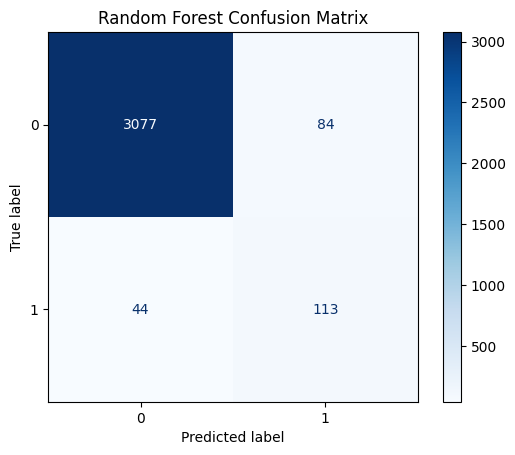

In [17]:
# Print matrix
cm_RF = metrics.confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:")
print(cm_RF)

# Optional: visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

WE have high recall here which is good for fraud detection as we do not want to miss any fradulent ransaction but if any non fraud transaction marked as fraudulet then system can review and proceed further!

In [20]:
import joblib

# Save the model to a local file
joblib.dump(rf_model, "model.joblib")


['model.joblib']

In [21]:
loaded_model = joblib.load('model.joblib')

In [22]:
y_pred_loaded = loaded_model.predict(X_test)
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print(f"Loaded Model Accuracy: {accuracy_loaded:.4f}")

Loaded Model Accuracy: 0.9614


In [23]:
import sklearn
import joblib

# Print version of scikit-learn and joblib
print(f"scikit-learn version: {sklearn.__version__}")
print(f"joblib version: {joblib.__version__}")


scikit-learn version: 1.5.2
joblib version: 1.4.2


In [24]:
# Upload to GCS
!gsutil cp model.joblib gs://$BUCKET_NAME/model_dir/model.joblib


Copying file://model.joblib [Content-Type=application/octet-stream]...
/ [1 files][ 13.3 MiB/ 13.3 MiB]                                                
Operation completed over 1 objects/13.3 MiB.                                     


In [25]:
from google.cloud import storage
import joblib

# Initialize the GCS client
client = storage.Client()

# Specify the bucket and model file path
bucket_name = 'movielensestorage'
model_blob_name = 'model_dir/model.joblib'

# Reference the GCS bucket and blob
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(model_blob_name)

# Download the model file to local disk
local_model_path = '/tmp/model.joblib'
blob.download_to_filename(local_model_path)

print(f'Model downloaded to {local_model_path}')


Model downloaded to /tmp/model.joblib


In [26]:
# Load the model using joblib
model2 = joblib.load('/tmp/model.joblib')
print('Model loaded successfully.')

# You can now use the model to make predictions


Model loaded successfully.


In [27]:
import pandas as pd

# Prepare your input data (make sure the features match what the model expects)
input_data = pd.DataFrame({
    'user_count_transactions_7d__transaction_count_7d': [10],
    'user_account_features__credit_score': [700],
    'user_account_features__account_age_days': [365],
    'user_account_features__user_has_2fa_installed': [1],
    'user_has_fraudulent_transactions__user_has_fraudulent_transactions_7d': [0]
})

# Make predictions
predictions = model2.predict(input_data)
print(f'Predictions: {predictions}')


Predictions: [0]


In [28]:
from google.cloud import aiplatform

aiplatform.init(
    project=PROJECT_ID,
    location="us-central1",  
    staging_bucket="gs://movielensestorage",
)


In [29]:
model = aiplatform.Model.upload(
    display_name="random-forest-fraud-detection-model7",
    artifact_uri="gs://movielensestorage/model_dir/", 
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-5:latest",
    serving_container_environment_variables={
        "MODEL_FILENAME": "model.joblib"
    }
)

Creating Model
Create Model backing LRO: projects/738666983022/locations/us-central1/models/703191562032513024/operations/7268924800620298240
Model created. Resource name: projects/738666983022/locations/us-central1/models/703191562032513024@1
To use this Model in another session:
model = aiplatform.Model('projects/738666983022/locations/us-central1/models/703191562032513024@1')


In [30]:
endpoint = model.deploy(
    deployed_model_display_name="rf-fraud-detector7",
    machine_type="n1-standard-2",
)


Creating Endpoint
Create Endpoint backing LRO: projects/738666983022/locations/us-central1/endpoints/8312823576939986944/operations/2910355154999967744
Endpoint created. Resource name: projects/738666983022/locations/us-central1/endpoints/8312823576939986944
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/738666983022/locations/us-central1/endpoints/8312823576939986944')
Deploying model to Endpoint : projects/738666983022/locations/us-central1/endpoints/8312823576939986944
Deploy Endpoint model backing LRO: projects/738666983022/locations/us-central1/endpoints/8312823576939986944/operations/5494506547436322816
Endpoint model deployed. Resource name: projects/738666983022/locations/us-central1/endpoints/8312823576939986944


In [80]:
!feast materialize-incremental $(date -u +"%Y-%m-%dT%H:%M:%S")

/opt/conda/lib/python3.10/site-packages/feast/repo_config.py:268: RuntimeWarning: `entity_key_serialization_version` is either not specified in the feature_store.yaml, or is specified to a value <= 1.This serialization version may cause errors when trying to write fields with the `Long` data type into the online store. Specifying `entity_key_serialization_version` to 2 is recommended for new projects. 
  warnings.warn(
Materializing 3 feature views to 2025-04-14 18:16:47+00:00 into the redis online store.

user_count_transactions_7d from 2025-04-07 18:16:53+00:00 to 2025-04-14 18:16:47+00:00:
100%|████████████████████████████████████████████████████████| 9525/9525 [00:00<00:00, 24919.44it/s]
user_account_features from 2024-04-15 18:16:56+00:00 to 2025-04-14 18:16:47+00:00:
100%|████████████████████████████████████████████████████████| 9944/9944 [00:00<00:00, 16060.04it/s]
user_has_fraudulent_transactions from 2024-04-15 18:16:58+00:00 to 2025-04-14 18:16:47+00:00:
100%|████████████████

In [32]:
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict

def predict(entity_rows):
    # Fetch feature data from Feast
    feature_vector = store.get_online_features(
        features=[
            "user_count_transactions_7d:transaction_count_7d",
            "user_account_features:credit_score",
            "user_account_features:account_age_days",
            "user_account_features:user_has_2fa_installed",
            "user_has_fraudulent_transactions:user_has_fraudulent_transactions_7d"
        ],
        entity_rows=entity_rows
    ).to_dict()

    # Delete entity keys
    del feature_vector["user_id"]

    # Flatten the response from Feast
    instances = [
        [feature_values[i] for feature_values in feature_vector.values()]
        for i in range(len(entity_rows))
    ]
    
    ENDPOINT_ID = "8312823576939986944"
    # Initialize Vertex AI SDK with the project and endpoint
    aiplatform.init(project=PROJECT_ID, location="us-central1")  # You can set location if necessary

    # Define the endpoint where the model is deployed
    endpoint = aiplatform.Endpoint(endpoint_name="projects/738666983022/locations/us-central1/endpoints/8312823576939986944")

    # Predict online using the deployed model
    prediction = endpoint.predict(instances=instances)

    # Return the prediction response
    return prediction.predictions


# Test the prediction function with an entity row
response = predict([{"user_id": "v5zlw0"}])
print(response)


[0.0]
